In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1rEHG_DS8ullcaZr4gI1gBBq9-X3TcTFH',
                                    dest_path='/content/Original-Communities.txt')

In [3]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1RaMNOQeN1yjDVTbI2mlW6EXiS29a9mF9',
                                    dest_path='/content/PPI-Net.txt')

In [4]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='17raGTKbLMLdeneMw1GB_MVBJVogaWPqK',
                                    dest_path='/content/idencap.zip')

In [5]:
!unzip /content/idencap.zip

Archive:  /content/idencap.zip
  inflating: mouse-ppi.txt           
  inflating: human-ppi.txt           
  inflating: human-complexes.txt     
  inflating: mouse-complexes.txt     


In [6]:
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import math
from scipy import sparse
import random
#define path of graph file and communities file
labelfile = '/content/mouse-complexes.txt'
graphfile =  '/content/mouse-ppi.txt'
#select number of communities with maximum members
n = 623

In [7]:
comm = []
f = open(labelfile)
for line in f:
  for i in line.split():
    if i not in comm:
      comm.append(i)

In [8]:
def loadData(labelfile, graphfile):
  data = []
  n_communities = []
  count = 0
  #save all communities in list-data regardless of the order
  with open(labelfile) as inputfile:
      for line in inputfile:
          data.append(line.split())
  graph = {}
  #save n communities with maximum members in list-n_communities keeping the decreasing order of length
  # print(data)
  for i in range(n):
    # print(i)
       p = max(data,key=len)
       n_communities.append(p)
       data.remove(p)
  with open(graphfile) as inputfile:
        for line in inputfile:
            node = line.split()[0]#read 1st element in any column(node 1)
            neigh = line.split()[1]#read 2nd element in any column(node 2)

            #Not include those nodes, which are not in n_communities
            g = 0
            for i in range(n):
              #  print(i)
               if( node in n_communities[i]):
                     g=1
            if g==0:
              count = count + 1
              continue
            g1=0
            for i in range(len(n_communities)):
               if( neigh in n_communities[i]):
                     g1=1
            if g1==0:
              count = count + 1
              continue
            #save all the nodes and edges, which are common to the graphfile and n_communities
            # if len(graph)>=500:
            #    return n_communities, graph
            # if node in comm:
            #    if node in graph:
            #        graph[node].add(neigh)
            #    else:
            #        graph[node] = {neigh}
            # if neigh in comm:
            #    if neigh in graph and neigh in comm:
            #        graph[neigh].add(node)
            #    else:
            #        graph[neigh] = {node}
            if node in graph:
                graph[node].add(neigh)
            else:
                graph[node] = {neigh}
            if neigh in graph:
                graph[neigh].add(node)
            else:
                graph[neigh] = {node}
  return n_communities, graph

In [9]:
def preprocessingData(graph, n_communities):
  adj_matrix = np.zeros((len(graph), len(graph)))
  node_index = {}
  j = 0
  for i in graph:
    node_index[i] = j
    j += 1
  for i in node_index:
    for j in graph[i]:
      if(j in node_index):
        adj_matrix[node_index[i]][node_index[j]] = 1
  label = np.zeros((len(graph), n))
  T = []
  for nodeId in node_index:
    u=[]
    for i in n_communities:
      if nodeId in i:
        u.append(n_communities.index(i))
    T.append(u)
    label[node_index[nodeId]]=labeller(u)
  return sparse.coo_matrix(adj_matrix),label,node_index,T

In [10]:
def Degreematrix(graph, n_communities,node_index):
  degree_matrix = np.zeros((len(graph), len(graph)))
  for i in node_index:
    degree_matrix[node_index[i]][node_index[i]] = len(graph[i])
  return sparse.coo_matrix(degree_matrix)

In [11]:
def labeller(pos):
  p = [0]*n
  for i in pos:
     p[i]=1
  return  p

In [12]:
n_communities,graph = loadData(labelfile, graphfile)

In [13]:
adj_matrix, label,nd,T = preprocessingData(graph, n_communities)

In [14]:
degree_matrix = Degreematrix(graph, n_communities,nd)

In [15]:
feature_matrix = sparse.coo_matrix(np.eye(len(graph)))
adj_matrix = adj_matrix + feature_matrix

In [16]:
from scipy import sparse
d = sparse.linalg.inv(degree_matrix)
d.data = np.sqrt(d.data)
normalized_adjecency = sparse.coo_matrix(d.multiply(adj_matrix.multiply(d)))

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:138: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:208: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


In [17]:
del adj_matrix
del degree_matrix


In [18]:
train_index = []
for i in range(len(graph)):
    train_index.append(i)

In [19]:
p = label.astype("int32").tolist()

In [20]:
K= []
for i in p:
  K.append(tuple(i))

In [21]:
Gk = {}
count = 0
for i in set(K):
  Gk[i] = count
  count = count + 1

In [22]:
labels = []
for i in p:
  h = [0]*count
  h[Gk[tuple(i)]] = 1
  labels.append(h)

In [23]:

features = tf.sparse_placeholder(tf.float32,shape=[len(graph),len(graph)])
y = tf.sparse_placeholder(tf.float32,shape = [len(graph),len(graph)])
label1 = tf.placeholder(tf.float32, shape = ((len(graph),count)))
weights1 = tf.Variable(tf.random_normal([len(graph),512], stddev = 1))
weights2 = tf.Variable(tf.random_normal([512,count], stddev = 1))
trainIndex = tf.placeholder(tf.int32, shape = ((len(train_index))))
#Defining GCN layer

In [24]:
def dot(x, y, sparse=False):
         if sparse:
             res = tf.sparse_tensor_dense_matmul(x, y)
         else:
             res = tf.matmul(x, y)
         return res
def layer(features, y,sparse, weights):
        with tf.name_scope('gcn_layer'):
            kernel = dot(features, weights,sparse)
            return tf.nn.relu(dot(y, kernel,True))


In [25]:
adj_coo_matrix = tf.SparseTensorValue(
    indices=np.array([normalized_adjecency.row, normalized_adjecency.col]).T,
    values=normalized_adjecency.data,
    dense_shape=normalized_adjecency._shape)

In [26]:
feature_coo_matrix = tf.SparseTensorValue(
    indices=np.array([feature_matrix.row, feature_matrix.col]).T,
    values=feature_matrix.data,
    dense_shape=feature_matrix._shape)

In [27]:
#Building with GCN layer     
hidden1 = layer(features,y,True, weights1)
hidden1 = tf.layers.dropout(hidden1, rate=0.5)
model = layer(hidden1,y,False,weights2)
training_output = tf.gather(model, trainIndex)

Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [28]:
#Defining loss function and optimizer
with tf.name_scope('loss'):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = training_output, labels = np.array(labels)))
        train_op = tf.train.AdamOptimizer(0.01, 0.90).minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [29]:
#creating session
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

#training up to 2000 epochs
for i in range(400):
        _, cost = sess.run([train_op, loss], feed_dict = {y:adj_coo_matrix,features:feature_coo_matrix, label1: np.array(labels), trainIndex: train_index})
        if(i%1 == 0):
            output= sess.run(model, feed_dict = {y:adj_coo_matrix,features:feature_coo_matrix,label1: np.array(labels)})
            predict = sess.run(tf.nn.softmax(model), feed_dict = {y:adj_coo_matrix,features:feature_coo_matrix,label1: np.array(labels)})
        print("epoch:",i) 

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
epoch: 66
epoch: 67
epoch: 68
epoch: 69
epoch: 70
epoch: 71
epoch: 72
epoch: 73
epoch: 74
epoch: 75
epoch: 76
epoch: 77
epoch: 78
epoch: 79
epoch: 80
epoch: 81
epoch: 82
epoch: 83
epoch: 84
epoch: 85
epoch: 86
epoch: 87
epoch: 88
epoch: 89
epoch: 90
epoch: 91
epoch: 92
epoch: 93
epoch: 94
epoch: 95
epoch: 96
epoch: 97
epoch: 98
epoch: 99
epoch: 100

In [30]:
K = []
for i in range(len(T)):
  l = []
  for j in range(len(T[i])):
    l.append(T[i][j]+1)
  K.append(l)

In [31]:
for i in range(len(K)):
  for j in range(10):
    if len(K[i])!=10:
      K[i].append(0)

In [32]:
output1 = []
for i in output:
  output1.append(list(i))

In [33]:
X_train = np.array(output1)

In [34]:
y_train = []
for i in K:
  L = [0]*n
  for j in i:
    if j>0:
      L[j-1] = 1
  y_train.append(L)

# **AffinityPropagation**

In [35]:
method = "AffinityPropagation_"

In [36]:
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import AffinityPropagation
from matplotlib import pyplot
# define dataset
model = AffinityPropagation(damping=0.9)
# fit the model
model.fit(X_train)
# assign a cluster to each example
yhat = model.predict(X_train)
# retrieve unique clusters
clusters = unique(yhat)

In [37]:
A = []
for i in range(max(list(yhat))):
  A.append([])
for i in range(len(list(yhat))):
  A[list(yhat)[i]-1].append(i)

In [38]:
G={}
for i in range(len(list(y_train))):
  G[i] = [j for j,x in enumerate(list(y_train[i])) if x == 1]
final_L = []
for i in range(n):
  final_L.append([])
for i in G:
  for j in G[i]:
    final_L[j].append(i)
with open(str(n) +'_original_communities.txt', 'w') as file:
    for item in final_L:
      for o in item:
            file.write("%s" % o + "\t")
      file.write("\n")

In [39]:
g = open("/content/" +str(n) +"_original_communities_result.txt","w")
for i in A:
  for j in i:
    g.write(str(j) +"\t")
  g.write("\n")
g.close()

In [40]:
f = open("/content/" +str(n) +"_original_communities_result.txt","r")
g = open("/content/" + method +str(n) +"_original_communities_result.txt","w")
for line in f:
  for i in line.split():
    g.write(list(nd.keys())[int(i)] +"\t")
  g.write("\n")
g.close()
f.close()

# ***Evaluation Metrics***

In [41]:
L = []
g = open("/content/" +str(n) +"_original_communities.txt","r")
for line in g:
  if len(line.split())>0:
     L.append(line.split())
print(len(L))

468


Total Predicted Complexes

In [42]:
R = []
g = open("/content/" +str(n) +"_original_communities_result.txt","r")
for line in g:
  if len(line.split())>0:
     R.append(line.split())
print(len(R))

128


Checking for Overlapping Scores and calculating number of matching sets

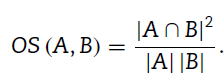

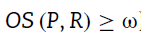

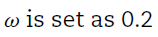

In [43]:
M_L = set()
M_R = set()
k = 0
for i in R:
  for j in L:
    #  print("i: ",R.index(i))
    #  print("j: ",L.index(j))
     if len(set(i).intersection(set(j)))**2/(len(i)*len(j))>=0.2:
       M_R.add(frozenset(i))
       M_L.add(frozenset(j))
       k = k +1
      #  print("k: ",k)

Known Matched Complexes

In [44]:
print(len(M_L))

167


Predicted Matched Complexes



In [45]:
print(len(M_R))

118


Recall

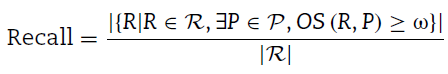

In [46]:
r = len(M_R)/len(R)
print(r)

0.921875


Precision

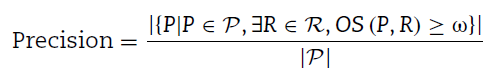

In [47]:
p = len(M_L)/len(L)
print(p)

0.35683760683760685


f-measure

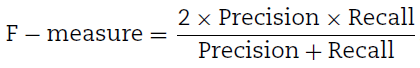

In [48]:
f_measure = (2*p*r)/(p+r)
print(f_measure)

0.5145169712793733


# **MeanShift**

In [49]:
method = "AffinityPropagation_"

In [50]:
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import MeanShift
from matplotlib import pyplot
# define dataset
model = MeanShift()
# fit model and predict clusters
yhat = model.fit_predict(X_train)
# retrieve unique clusters
clusters = unique(yhat)

In [51]:
A = []
for i in range(max(list(yhat))+1):
  A.append([])
for i in range(len(list(yhat))):
  A[list(yhat)[i]].append(i)

In [52]:
g = open("/content/" +str(n) +"_original_communities_result.txt","w")
for i in A:
  for j in i:
    g.write(str(j) +"\t")
  g.write("\n")
g.close()

In [53]:
f = open("/content/" +str(n) +"_original_communities_result.txt","r")
g = open("/content/" + method +str(n) +"_original_communities_result.txt","w")
for line in f:
  for i in line.split():
    g.write(list(nd.keys())[int(i)] +"\t")
  g.write("\n")
g.close()
f.close()

# ***Evaluation Metrics***

In [54]:
L = []
g = open("/content/" +str(n) +"_original_communities.txt","r")
for line in g:
  if len(line.split())>0:
     L.append(line.split())
print(len(L))

468


Total Predicted Complexes

In [55]:
R = []
g = open("/content/" +str(n) +"_original_communities_result.txt","r")
for line in g:
  if len(line.split())>0:
     R.append(line.split())
print(len(R))

139


Checking for Overlapping Scores and calculating number of matching sets

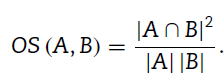

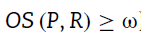

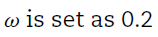

In [56]:
M_L = set()
M_R = set()
k = 0
for i in R:
  for j in L:
    #  print("i: ",R.index(i))
    #  print("j: ",L.index(j))
     if len(set(i).intersection(set(j)))**2/(len(i)*len(j))>=0.2:
       M_R.add(frozenset(i))
       M_L.add(frozenset(j))
       k = k +1
      #  print("k: ",k)

Known Matched Complexes

In [57]:
print(len(M_L))

167


Predicted Matched Complexes



In [58]:
print(len(M_R))

121


Recall

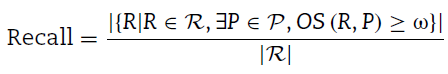

In [59]:
r = len(M_R)/len(R)
print(r)

0.8705035971223022


Precision

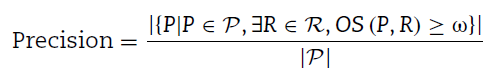

In [60]:
p = len(M_L)/len(L)
print(p)

0.35683760683760685


f-measure

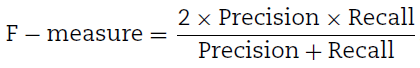

In [61]:
f_measure = (2*p*r)/(p+r)
print(f_measure)

0.5061810348066783


# **OPTICS**

In [62]:
method = "AffinityPropagation_"

In [63]:

# optics clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import OPTICS
from matplotlib import pyplot
model = OPTICS(eps=0.8, min_samples=2)
# fit model and predict clusters
yhat = model.fit_predict(X_train)
# retrieve unique clusters
clusters = unique(yhat) 

In [64]:
A = []
for i in range(max(list(yhat))+1+1):
  A.append([])
for i in range(len(list(yhat))):
  A[list(yhat)[i]+1].append(i)

In [65]:
g = open("/content/" +str(n) +"_original_communities_result.txt","w")
for i in A:
  for j in i:
    g.write(str(j) +"\t")
  g.write("\n")
g.close()

In [66]:
f = open("/content/" +str(n) +"_original_communities_result.txt","r")
g = open("/content/" + method +str(n) +"_original_communities_result.txt","w")
for line in f:
  for i in line.split():
    g.write(list(nd.keys())[int(i)] +"\t")
  g.write("\n")
g.close()
f.close()

# ***Evaluation Metrics***

In [67]:
L = []
g = open("/content/" +str(n) +"_original_communities.txt","r")
for line in g:
  if len(line.split())>0:
     L.append(line.split())
print(len(L))

468


Total Predicted Complexes

In [68]:
R = []
g = open("/content/" +str(n) +"_original_communities_result.txt","r")
for line in g:
  if len(line.split())>0:
     R.append(line.split())
print(len(R))

24


Checking for Overlapping Scores and calculating number of matching sets

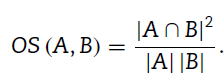

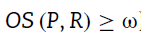

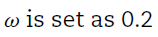

In [69]:
M_L = set()
M_R = set()
k = 0
for i in R:
  for j in L:
    #  print("i: ",R.index(i))
    #  print("j: ",L.index(j))
     if len(set(i).intersection(set(j)))**2/(len(i)*len(j))>=0.2:
       M_R.add(frozenset(i))
       M_L.add(frozenset(j))
       k = k +1
      #  print("k: ",k)

Known Matched Complexes

In [70]:
print(len(M_L))

23


Predicted Matched Complexes



In [71]:
print(len(M_R))

18


Recall

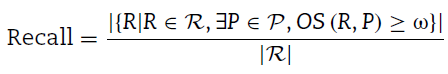

In [72]:
r = len(M_R)/len(R)
print(r)

0.75


Precision

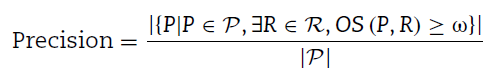

In [73]:
p = len(M_L)/len(L)
print(p)

0.049145299145299144


f-measure

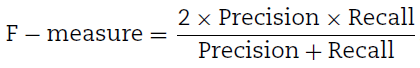

In [74]:
f_measure = (2*p*r)/(p+r)
print(f_measure)

0.09224598930481283
